## **Instalasi Library**

In [ ]:
!pip -q install speechrecognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 16.2 MB/s eta 0:00:00


In [ ]:
!pip -q install gtts

In [ ]:
!pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 22.7 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.12.3
    Uninstalling tensorboard-2.12.

# **Import Library**

In [ ]:
# Import Libraries
import json
import nltk
import time
import random
import string
import pickle
import numpy as np
import pandas as pd
from gtts import gTTS
from io import BytesIO
import tensorflow as tf
import IPython.display as ipd
import speech_recognition as sr
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Model
from keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPool1D

## **Download NLTK Package**

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

# **Load Dataset Json**

In [ ]:
# Importing the dataset
with open('datasets.json') as content:
  data1 = json.load(content)

# Mendapatkan semua data ke dalam list
tags = [] # data tag
inputs = [] # data input atau pattern
responses = {} # data respon
words = [] # Data kata
classes = [] # Data Kelas atau Tag
documents = [] # Data Kalimat Dokumen
ignore_words = ['?', '!'] # Mengabaikan tanda spesial karakter

for intent in data1['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['patterns']:
    inputs.append(lines)
    tags.append(intent['tag'])
    for pattern in intent['patterns']:
      w = nltk.word_tokenize(pattern)
      words.extend(w)
      documents.append((w, intent['tag']))
      # add to our classes list
      if intent['tag'] not in classes:
        classes.append(intent['tag'])

# Konversi data json ke dalam dataframe
data = pd.DataFrame({"patterns":inputs, "tags":tags})

In [ ]:
data

,patterns,tags
0,hallo,greeting
1,hai,greeting
2,halo,greeting
3,hei,greeting
4,hi,greeting
...,...,...
78,Siapa nama kepala desa di Desa Wonorejo?,nama_kepala_desa
79,Bagaimana persebaran agama di Desa Wonorejo?,persebaran_agama_desa
80,Apa saja agama di Desa Wonorejo?,persebaran_agama_desa
81,Siapa yang mendirikan desa Wonorejo?,pendiri_desa_wonorejo


In [ ]:
data.head() # Cetak data baris pertama sampai baris kelima

,patterns,tags
0,hallo,greeting
1,hai,greeting
2,halo,greeting
3,hei,greeting
4,hi,greeting


In [ ]:
data.tail() # Cetak data baris ke-70 sampai baris akhir

,patterns,tags
78,Siapa nama kepala desa di Desa Wonorejo?,nama_kepala_desa
79,Bagaimana persebaran agama di Desa Wonorejo?,persebaran_agama_desa
80,Apa saja agama di Desa Wonorejo?,persebaran_agama_desa
81,Siapa yang mendirikan desa Wonorejo?,pendiri_desa_wonorejo
82,Desa Wonorejo didirikan oleh siapa?,pendiri_desa_wonorejo


# **Preprocessing The Data**



In [ ]:
# Removing Punctuations (Menghilangkan Punktuasi)
data['patterns'] = data['patterns'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['patterns'] = data['patterns'].apply(lambda wrd: ''.join(wrd))
data

,patterns,tags
0,hallo,greeting
1,hai,greeting
2,halo,greeting
3,hei,greeting
4,hi,greeting
...,...,...
78,siapa nama kepala desa di desa wonorejo,nama_kepala_desa
79,bagaimana persebaran agama di desa wonorejo,persebaran_agama_desa
80,apa saja agama di desa wonorejo,persebaran_agama_desa
81,siapa yang mendirikan desa wonorejo,pendiri_desa_wonorejo


In [ ]:
lemmatizer = WordNetLemmatizer()
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

print (len(words), "unique lemmatized words", words)

120 unique lemmatized words ['ada', 'adakah', 'administrasi', 'afternoon', 'agama', 'apa', 'apakah', 'asal', 'aspirasi', 'awal', 'badan', 'bagaimana', 'bai', 'banyak', 'berapa', 'bro', 'bumdes', 'bye', 'byee', 'ciri', 'contoh', 'dadah', 'dah', 'dalam', 'dapat', 'desa', 'di', 'dibutuhkan', 'didirikan', 'dikunjungi', 'dokumen', 'dusun', 'event', 'good', 'hai', 'hallo', 'halo', 'hei', 'hi', 'hy', 'ikonik', 'ini', 'itu', 'jumlah', 'jumpa', 'karang', 'kasih', 'kawan', 'kepadatan', 'kepala', 'kepemudaan', 'kependudukan', 'ketua', 'khas', 'kk', 'makasih', 'malam', 'mekanisme', 'memiliki', 'mendapat', 'mendirikan', 'menjabat', 'menjadi', 'milik', 'morning', 'mudah', 'mula', 'nama', 'oleh', 'organisasi', 'pagi', 'pelaporan', 'pelaporan/aspirasi', 'pelatihan', 'pelayanan', 'pembangunan', 'pemerintahan', 'pemilihan', 'pendataan', 'penduduk', 'pengantar', 'penyampaian', 'perangkat', 'persebaran', 'prose', 'rt', 'rutin', 'rw', 'saat', 'saja', 'sampai', 'sebutan', 'see', 'selamat', 'si', 'siang', 's

In [ ]:
# sort classes
classes = sorted(list(set(classes)))
print (len(classes), "classes", classes)

34 classes ['administrasi_kependudukan_desa', 'administrasi_pembangunan_desa', 'administrasi_umum_desa', 'asal_mula_desa', 'asal_nama_desa', 'bumdes_wonorejo', 'ciri_khas_desa', 'dusun_desa_wonorejo', 'event_unggulan_desa', 'goodbye', 'greeting', 'karang_taruna_desa', 'kepadatan_penduduk_desa', 'lapor_aspirasi_desa', 'mekanisme_pemilihan_perangkat_desa', 'mekanisme_pemilihan_rt', 'mekanisme_pemilihan_rw', 'mekanisme_pilkades', 'nama_kepala_desa', 'pelatihan_desa', 'pendataan_umkm_desa', 'pendiri_desa_wonorejo', 'penjelasan_desa_wonorejo', 'persebaran_agama_desa', 'rt_desa_wonorejo', 'rw_desa_wonorejo', 'sebutan_desa_wonorejo', 'sistem_pelayanan_desa', 'struktur_pemerintahan_desa', 'surat_pengantar_kades', 'tempat_ikonik_desa', 'tempat_wisata_desa', 'terimakasih', 'umkm_bumdes_wonorejo']


In [ ]:
# documents = combination between patterns and intents
print (len(documents), "documents")

441 documents


In [ ]:
# Tokenize the data (Tokenisasi Data)
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['patterns'])
train = tokenizer.texts_to_sequences(data['patterns'])
train

[[57],
 [58],
 [59],
 [60],
 [61],
 [62],
 [63],
 [64],
 [65],
 [66],
 [67],
 [68],
 [69],
 [70],
 [71],
 [72],
 [73],
 [29],
 [74],
 [75, 29],
 [76, 77],
 [78, 79],
 [80],
 [81, 30],
 [82],
 [83, 30],
 [31, 32],
 [84],
 [31, 32, 85],
 [4, 86, 1, 2],
 [6, 19, 14, 1, 2],
 [19, 14, 1, 2],
 [6, 19, 33, 1, 2],
 [87, 33, 1, 2],
 [4, 9, 88, 34, 35, 1, 2],
 [4, 7, 34, 35, 1, 2],
 [4, 7, 36, 37, 1, 2],
 [5, 1, 2, 8, 36, 37],
 [4, 7, 38, 1, 2],
 [5, 1, 2, 8, 38],
 [6, 20, 11, 1, 2],
 [5, 20, 11, 1, 2, 89],
 [5, 20, 11, 1, 2, 90],
 [12, 13, 39, 3, 1, 2],
 [4, 7, 39, 9, 12, 3, 1, 2],
 [12, 13, 40, 3, 1, 2],
 [12, 13, 41, 3, 1, 2],
 [5, 1, 2, 8, 15, 42],
 [4, 7, 15, 42, 1, 2],
 [4, 7, 21, 11, 22, 91, 3, 1, 2],
 [4, 7, 21, 11, 22, 92, 3, 1, 2],
 [4, 7, 21, 11, 22, 93, 3, 1, 2],
 [6, 94, 43, 1, 2],
 [4, 7, 95, 9, 96, 97, 98, 99, 100, 16, 1],
 [5, 1, 2, 44, 8, 8, 45, 1],
 [5, 1, 2, 44, 8, 45],
 [6, 10, 23, 101, 1],
 [6, 10, 23, 102, 1],
 [6, 10, 23, 103, 1],
 [104, 15, 46, 9, 105, 106, 3, 1, 2],
 [5,

In [ ]:
# Apply padding
x_train = pad_sequences(train)

# Encoding the outputs
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])

In [ ]:
print(x_train) # Padding Sequences

[[  0   0   0 ...   0   0  57]
 [  0   0   0 ...   0   0  58]
 [  0   0   0 ...   0   0  59]
 ...
 [  0   0   0 ...   3   1   2]
 [  0   0   0 ... 119   1   2]
 [  0   0   0 ... 120  54  18]]


In [ ]:
print(y_train) #Label Encodings

[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10  9  9  9  9  9  9  9  9  9
 32 32 32 32 32 22  4  4  3  3  6  6  8  8 26 26 27 27 27  7  7 24 25 30
 30  2  0  1 28 29 19 19 13 13 13 31 31 12 12 12 17 14 15 16  5  5  5 33
 33 20 11 11 11 18 18 23 23 21 21]


# **Input Length, Output Length and Vocabulary**



In [ ]:
# input length
input_shape = x_train.shape[1]
print(input_shape)

13


In [ ]:
# define vocabulary
vocabulary = len(tokenizer.word_index)
print("number of unique words : ", vocabulary)

# output length
output_length = le.classes_.shape[0]
print("output length: ", output_length)

number of unique words :  120
output length:  34


# **Save Model Words & Classes**

In [ ]:
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))

# **Neural Network Model**

In [ ]:
# Creating the model (Membuat Modeling)
i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1,10)(i) # Layer Embedding
x = LSTM(10, return_sequences=True)(x) # Layer Long Short Term Memory
x = Flatten()(x) # Layer Flatten
x = Dense(output_length, activation="softmax")(x) # Layer Dense
model  = Model(i,x)

# Compiling the model (Kompilasi Model)
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

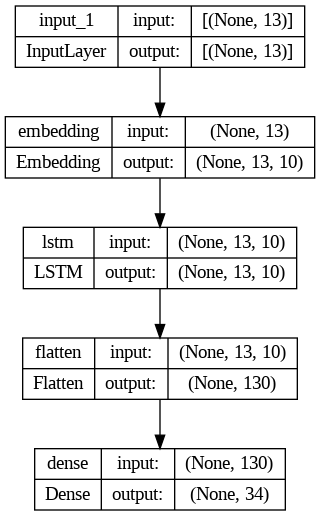

In [ ]:
# Visualization Plot Architecture Model (Visualisasi Plot Arsitektur Model)
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.summary() # Menampilkan Parameter Model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13)]              0         
                                                                 
 embedding (Embedding)       (None, 13, 10)            1210      
                                                                 
 lstm (LSTM)                 (None, 13, 10)            840       
                                                                 
 flatten (Flatten)           (None, 130)               0         
                                                                 
 dense (Dense)               (None, 34)                4454      
                                                                 
Total params: 6504 (25.41 KB)
Trainable params: 6504 (25.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Training the model (Latih Model Data)
train = model.fit(x_train, y_train, epochs=400)

Epoch 1/400
3/3 [==============================] - 6s 29ms/step - loss: 3.5265 - accuracy: 0.0241
Epoch 2/400
3/3 [==============================] - 0s 22ms/step - loss: 3.5214 - accuracy: 0.0361
Epoch 3/400
3/3 [==============================] - 0s 14ms/step - loss: 3.5165 - accuracy: 0.0723
Epoch 4/400
3/3 [==============================] - 0s 16ms/step - loss: 3.5109 - accuracy: 0.0723
Epoch 5/400
3/3 [==============================] - 0s 20ms/step - loss: 3.5045 - accuracy: 0.0602
Epoch 6/400
3/3 [==============================] - 0s 22ms/step - loss: 3.4964 - accuracy: 0.0602
Epoch 7/400
3/3 [==============================] - 0s 15ms/step - loss: 3.4860 - accuracy: 0.0843
Epoch 8/400
3/3 [==============================] - 0s 15ms/step - loss: 3.4743 - accuracy: 0.1807
Epoch 9/400
3/3 [==============================] - 0s 15ms/step - loss: 3.4581 - accuracy: 0.1566
Epoch 10/400
3/3 [==============================] - 0s 16ms/step - loss: 3.4404 - accuracy: 0.1325
Epoch 11/400
3/3 [=

# **Model Analysis**

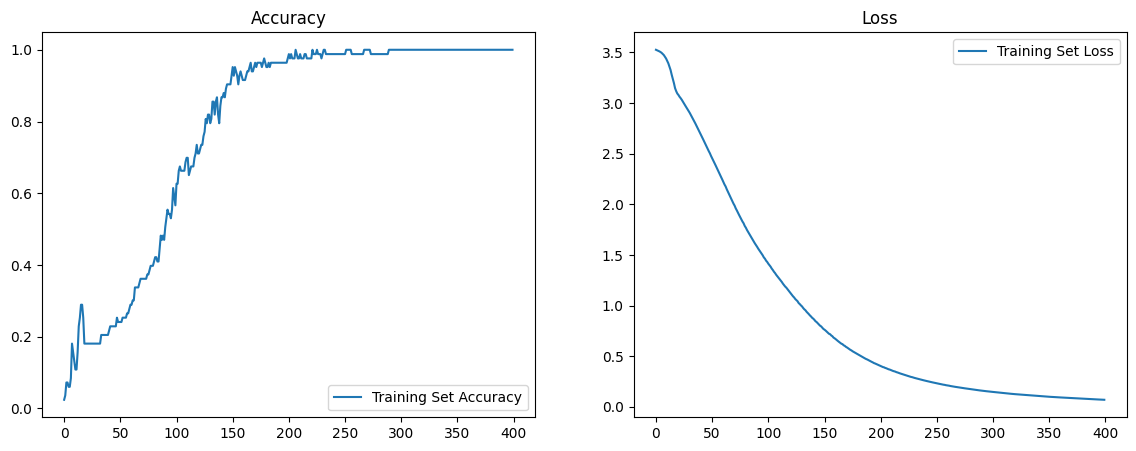

In [ ]:
# Plotting model Accuracy and Loss (Visualisasi Plot Hasil Akurasi dan Loss)
# Plot Akurasi
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train.history['accuracy'],label='Training Set Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train.history['loss'],label='Training Set Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

# **Testing Chatbot**

In [ ]:
# Membuat Input Chat
while True:
  texts_p = []
  prediction_input = input('Anda : ')

  # Menghapus punktuasi dan konversi ke huruf kecil
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  # Tokenisasi dan Padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],input_shape)

  # Mendapatkan hasil keluaran pada model
  output = model.predict(prediction_input)
  output = output.argmax()

  # Menemukan respon sesuai data tag dan memainkan voice bot
  response_tag = le.inverse_transform([output])[0]
  print("Min-Wo : ", random.choice(responses[response_tag]))
  tts = gTTS(random.choice(responses[response_tag]), lang='id')
  tts.save('chatbot.wav')
  time.sleep(0.08)
  ipd.display(ipd.Audio('chatbot.wav', autoplay=True))
  print("="*60 + "\n")
  if response_tag == "goodbye":
    break

Anda : Halo
1/1 [==============================] - 0s 94ms/step
Min-Wo :  Hai! Min-Wo di sini. Mau tau informasi tentang apa nih?



Anda : apa itu desa wonorejo?
1/1 [==============================] - 0s 55ms/step
Min-Wo :  Desa Wonorejo merupakan desa yang berada di wilayah kecamatan Polokarto, kabupaten Sukoharjo, Jawa Tengah



Anda : selamat tinggal
1/1 [==============================] - 0s 24ms/step
Min-Wo :  Sampai jumpa lagi!


# **Save The Model**

In [ ]:
model.save('chatbot_model.h5')

print('Model Created Successfully!')

Model Created Successfully!


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.9/189.9 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 59.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 23.1
    Uninstalling packaging-23.1:
      Successfully uninstalled packaging-23.1
  Attempting uninstall: flax
    Found existing installation: flax 0.7.2
    Uninstalling flax-0.7.2:
      Successfully uninstalled flax-0.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
statsmodels 0.14.0 requires packaging>=21.3, but you have packaging 20.9 which is incompatible.
xarray 2023.7.0 requires packaging>=21.3, but you have packaging 20.9 which is incompatible.


In [ ]:
!tensorflowjs_converter --input_format keras chatbot_model.h5 tfjs_model

2023-08-23 23:14:54.490553: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-23 23:14:57.566760: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
